In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [21]:
class SyntheticShapesDataset(Dataset):
    def __init__(self, num_images, image_size=(128, 128), colors=["red", "green", "blue", "orange", "purple", "brown"], shape_types=["circle", "square", "rectangle", "triangle"]):
        self.num_images = num_images
        self.image_size = image_size
        self.colors = colors
        self.shape_types = shape_types

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        shape_type = np.random.choice(self.shape_types)
        color = np.random.choice(self.colors)
        image, mask = self.generate_image_and_mask(shape_type, color)
        return torch.from_numpy(image).permute(2, 0, 1).float(), torch.from_numpy(mask).unsqueeze(0).float()

    def generate_image_and_mask(self, shape_type, color):
        background_colors = [c for c in self.colors if c != color]
        background_color = np.random.choice(background_colors) if background_colors else "white"

        image = Image.new("RGB", self.image_size, color=background_color)
        mask = Image.new("L", self.image_size, color=0)

        draw_image = ImageDraw.Draw(image)
        draw_mask = ImageDraw.Draw(mask)

        if shape_type == "circle":
            radius = np.random.randint(20, min(self.image_size) // 4)
            upper_left = (np.random.randint(0, self.image_size[0] - radius),
                          np.random.randint(0, self.image_size[1] - radius))
            lower_right = (upper_left[0] + radius, upper_left[1] + radius)
            draw_image.ellipse([upper_left, lower_right], fill=color)
            draw_mask.ellipse([upper_left, lower_right], fill=255)

        elif shape_type == "square":
            side = np.random.randint(20, min(self.image_size) // 4)
            upper_left = (np.random.randint(0, self.image_size[0] - side),
                          np.random.randint(0, self.image_size[1] - side))
            lower_right = (upper_left[0] + side, upper_left[1] + side)
            draw_image.rectangle([upper_left, lower_right], fill=color)
            draw_mask.rectangle([upper_left, lower_right], fill=255)

        elif shape_type == "rectangle":
            width = np.random.randint(20, self.image_size[0] // 4)
            height = np.random.randint(20, self.image_size[1] // 4)
            upper_left = (np.random.randint(0, self.image_size[0] - width),
                          np.random.randint(0, self.image_size[1] - height))
            lower_right = (upper_left[0] + width, upper_left[1] + height)
            draw_image.rectangle([upper_left, lower_right], fill=color)
            draw_mask.rectangle([upper_left, lower_right], fill=255)

        elif shape_type == "triangle":
            point1 = (np.random.randint(0, self.image_size[0]),
                      np.random.randint(0, self.image_size[1]))
            point2 = (np.random.randint(0, self.image_size[0]),
                      np.random.randint(0, self.image_size[1]))
            point3 = (np.random.randint(0, self.image_size[0]),
                      np.random.randint(0, self.image_size[1]))
            draw_image.polygon([point1, point2, point3], fill=color)
            draw_mask.polygon([point1, point2, point3], fill=255)

        return np.array(image), np.array(mask)


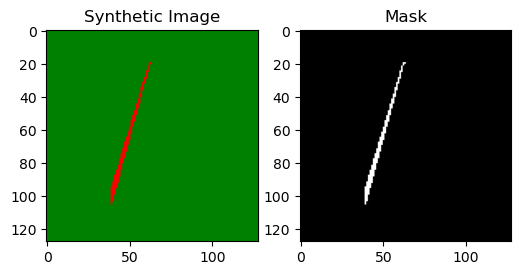

In [22]:
updated_dataset = SyntheticShapesDataset(100)
image, mask = updated_dataset[0]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0).numpy().astype(np.uint8))
plt.title("Synthetic Image")
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze().numpy(), cmap="gray")
plt.title("Mask")
plt.show()

In [23]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downscaling
        self.down_conv1 = self.conv_stage(3, 16)
        self.down_conv2 = self.conv_stage(16, 32)
        self.down_conv3 = self.conv_stage(32, 64)
        self.down_conv4 = self.conv_stage(64, 128)

        # Bottleneck
        self.bottleneck = self.conv_stage(128, 256)

        # Upscaling
        self.up_conv4 = self.conv_stage(256 + 128, 128)
        self.up_conv3 = self.conv_stage(128 + 64, 64)
        self.up_conv2 = self.conv_stage(64 + 32, 32)
        self.up_conv1 = self.conv_stage(32 + 16, 16)

        # Output layer
        self.final_layer = nn.Conv2d(16, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_stage(self, in_channels, out_channels):
        conv_stage = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv_stage

    def forward(self, x):
        # Downscaling
        conv1 = self.down_conv1(x)
        x = F.max_pool2d(conv1, 2)
        conv2 = self.down_conv2(x)
        x = F.max_pool2d(conv2, 2)
        conv3 = self.down_conv3(x)
        x = F.max_pool2d(conv3, 2)
        conv4 = self.down_conv4(x)
        x = F.max_pool2d(conv4, 2)

        # Bottleneck
        x = self.bottleneck(x)

        # Upscaling + concatenate
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat([x, conv4], dim=1)
        x = self.up_conv4(x)
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat([x, conv3], dim=1)
        x = self.up_conv3(x)
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat([x, conv2], dim=1)
        x = self.up_conv2(x)
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat([x, conv1], dim=1)
        x = self.up_conv1(x)

        # Output
        x = self.final_layer(x)
        x = self.sigmoid(x)
        return x


In [24]:
train_dataset = SyntheticShapesDataset(500)
val_dataset = SyntheticShapesDataset(100)

In [25]:
def iou_score(output, target, threshold=0.5):
    # Apply sigmoid to output and detach from the computation graph
    output = output.detach()

    # Convert outputs and targets to boolean tensors
    output_bool = output > threshold
    target_bool = target > threshold

    # Perform bitwise operations on boolean tensors
    intersection = (output_bool & target_bool).float().sum((1, 2))
    union = (output_bool | target_bool).float().sum((1, 2))

    smooth = 1e-6
    iou = (intersection + smooth) / (union + smooth)  # Avoid division by zero
    return iou.mean()

In [26]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [27]:
model = UNet()

In [28]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_iou, train_dice = 0.0, 0.0

        # Training loop
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks/255)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_iou += iou_score(outputs, masks/255).item()
            

        # Average over the dataset
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_iou, val_dice = 0.0, 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks/255)
                val_loss += loss.item()
                val_iou += iou_score(outputs, masks/255).item()
                

        # Average over the dataset
        val_loss /= len(val_loader)
        val_iou /= len(val_loader)
        

        # Print metrics
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, IoU: {train_iou:.4f} - "
              f"Val loss: {val_loss:.4f}, IoU: {val_iou:.4f}")




In [31]:
train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

Epoch 1/15 - Train loss: 0.2711, IoU: 0.6850 - Val loss: 0.2222, IoU: 0.6509
Epoch 2/15 - Train loss: 0.1921, IoU: 0.7145 - Val loss: 0.2005, IoU: 0.7102
Epoch 3/15 - Train loss: 0.1502, IoU: 0.7393 - Val loss: 0.1557, IoU: 0.7582
Epoch 4/15 - Train loss: 0.1122, IoU: 0.7752 - Val loss: 0.0875, IoU: 0.8008
Epoch 5/15 - Train loss: 0.0875, IoU: 0.8123 - Val loss: 0.0786, IoU: 0.8312
Epoch 6/15 - Train loss: 0.0821, IoU: 0.8444 - Val loss: 0.0686, IoU: 0.8571
Epoch 7/15 - Train loss: 0.0794, IoU: 0.8469 - Val loss: 0.0584, IoU: 0.8876
Epoch 8/15 - Train loss: 0.0593, IoU: 0.8618 - Val loss: 0.0441, IoU: 0.9061
Epoch 9/15 - Train loss: 0.0343, IoU: 0.9198 - Val loss: 0.0362, IoU: 0.9036
Epoch 10/15 - Train loss: 0.0497, IoU: 0.9010 - Val loss: 0.0261, IoU: 0.9077
Epoch 11/15 - Train loss: 0.0186, IoU: 0.9463 - Val loss: 0.0139, IoU: 0.9578
Epoch 12/15 - Train loss: 0.0529, IoU: 0.9346 - Val loss: 0.0427, IoU: 0.8944
Epoch 13/15 - Train loss: 0.0309, IoU: 0.9331 - Val loss: 0.0183, IoU: 0.

In [32]:
torch.save(model, "unet_model.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


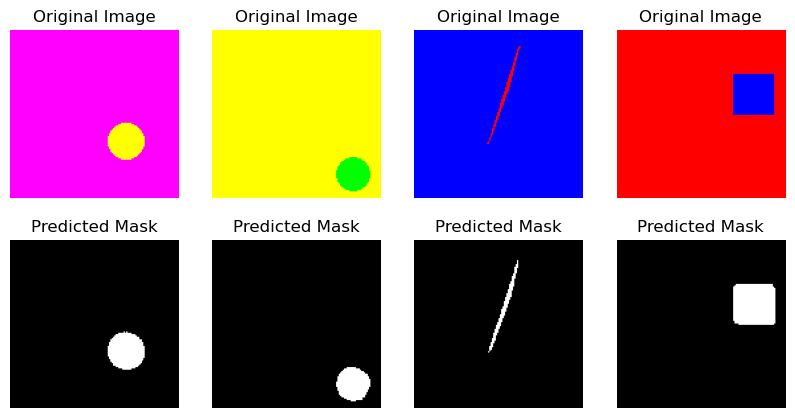

In [34]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)
    outputs =outputs > 0.5
    outputs = outputs * 255
    images = images.cpu()
    outputs = outputs.cpu()

    plt.figure(figsize=(10, 5))
    for i in range(4):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(2, 4, i + 5)
        plt.imshow(outputs[i].squeeze().numpy(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")
    plt.show()